In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
!gdown --id '1aV9YBc3wCMWE4KYbf-AW_6d8aF2cn8h6'

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aV9YBc3wCMWE4KYbf-AW_6d8aF2cn8h6
To: /content/spam.csv
100% 480k/480k [00:00<00:00, 104MB/s]


In [7]:
import pandas as pd

df=pd.read_csv('/content/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
#Checking the dataset depenent values
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

It has Some imbalace dataset that should be balanced before using this data into the model

In [9]:
df_spam=df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [10]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [12]:
df_hamdownsampled=df_ham.sample(df_spam.shape[0])
df_hamdownsampled.shape

(747, 2)

In [13]:
df_balaced=pd.concat([df_spam,df_hamdownsampled])

In [15]:
df_balaced.shape

(1494, 2)

In [18]:
df_balaced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [20]:
#Convert this into Numerical data
df_balaced['spam']=df_balaced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balaced.sample(5)

,Category,Message,spam
2544,ham,Package all your programs well,0
4464,ham,He said i look pretty wif long hair wat. But i...,0
65,spam,"As a valued customer, I am pleased to advise y...",1
4501,ham,Nvm take ur time.,0
4161,ham,i felt so...not any conveying reason.. Ese he....,0


In [21]:
#Spliting the data into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df_balaced['Message'],df_balaced['spam'],stratify=df_balaced['spam'])

In [23]:
#Applying the bert algorithm
encoder_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
preprocessed_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_encoder=hub.KerasLayer(encoder_url)
bert_preprocessed=hub.KerasLayer(preprocessed_url)

In [24]:
#Making a function to get the output of the text given
def get_sentence_embedding(sentences):
  preprocessed_text=bert_preprocessed(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    'Package all your programs well',
    'Nvm take ur time.'
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.9207181 , -0.388643  , -0.8817638 , ..., -0.56002146,
        -0.73291063,  0.92131793],
       [-0.8677612 , -0.4184335 , -0.82664907, ..., -0.81505865,
        -0.7308372 ,  0.8862172 ]], dtype=float32)>

In [26]:
e = get_sentence_embedding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606919 , -0.14219381,  0.4960461 , ...,  0.42165333,
        -0.532214  ,  0.80312175],
       [-0.86023223, -0.21242939,  0.4915689 , ...,  0.3979803 ,
        -0.60506296,  0.8447167 ],
       [-0.7128864 , -0.15463923,  0.38401636, ...,  0.352787  ,
        -0.5099134 ,  0.73474115],
       [-0.8253345 , -0.3555054 , -0.5906963 , ..., -0.01613662,
        -0.6141756 ,  0.87230295],
       [-0.7504134 , -0.26812598, -0.26689604, ...,  0.02839445,
        -0.5938098 ,  0.79749876],
       [-0.78544384, -0.299497  ,  0.41027427, ...,  0.5222542 ,
        -0.4957355 ,  0.81507534]], dtype=float32)>

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]],[e[-1]])

array([[0.95718384]], dtype=float32)

In [29]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocessed(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [31]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [32]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 606s 17s/step - loss: 0.6363 - accuracy: 0.6571 - precision: 0.6566 - recall: 0.6589
Epoch 2/10
35/35 [==============================] - 556s 16s/step - loss: 0.5009 - accuracy: 0.8277 - precision: 0.8169 - recall: 0.8446
Epoch 3/10
35/35 [==============================] - 559s 16s/step - loss: 0.4302 - accuracy: 0.8687 - precision: 0.8579 - recall: 0.8839
Epoch 4/10
35/35 [==============================] - 554s 16s/step - loss: 0.3870 - accuracy: 0.8813 - precision: 0.8833 - recall: 0.8786
Epoch 5/10
35/35 [==============================] - 553s 16s/step - loss: 0.3619 - accuracy: 0.8893 - precision: 0.8670 - recall: 0.9196
Epoch 6/10
35/35 [==============================] - 551s 16s/step - loss: 0.3367 - accuracy: 0.8893 - precision: 0.8811 - recall: 0.9000
Epoch 7/10
35/35 [==============================] - 548s 16s/step - loss: 0.3153 - accuracy: 0.8955 - precision: 0.8920 - recall: 0.9000
Epoch 8/10
35/35 [=======================

In [34]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 207s 16s/step - loss: 0.2938 - accuracy: 0.8957 - precision: 0.8458 - recall: 0.9679


[0.29380109906196594,
 0.8957219123840332,
 0.8457943797111511,
 0.9679144620895386]

In [35]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 191s 16s/step


In [36]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[154,  33],
       [  6, 181]])

Text(33.0, 0.5, 'Truth')

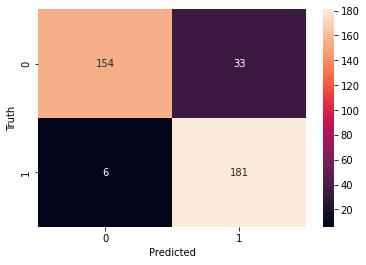

In [38]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [39]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89       187
           1       0.85      0.97      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [40]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 4s 4s/step


array([[0.7715314 ],
       [0.87429553],
       [0.8309343 ],
       [0.26497123],
       [0.16784053]], dtype=float32)

In [45]:
model.predict(['The chef is ready to cook. Just give us the green light!'])

1/1 [==============================] - 1s 861ms/step


array([[0.38850987]], dtype=float32)